In [1]:
#Yb-173 Spin Echo#


from qutip import*
from numpy import*
from sympy.physics.wigner import wigner_3j
import scipy.constants as C
import matplotlib.pyplot as plt


In [2]:
#定义常数/参数#


i = 0+1j # 虚数单位
hbar = C.h/(2*pi) # 约化普朗克常数
epsilon_0 = 8.854e-12 # 真空介电常数

u = array([0,1/sqrt(2),i/sqrt(2)]) # polarization vector
K = [0,1,2]

alpha_K = [1.5478800e-37,-1.4156930e-39,2.6744279e-40] # reduced polarizability
alpha_s_F = 3.6483882e-38
alpha_v_F = 6.9078745e-40
alpha_T_F = -5.3275879e-41
F = 5/2
M = [5/2,3/2,1/2,-1/2,-3/2,-5/2]

Hx = spin_Jx(F)
Hy = spin_Jy(F)
Hz = spin_Jz(F)

P = 4 #光功率(mW)
omega_0 = 550 #高斯光束腰半径(um)
detune = 270 #失谐(MHz)
A = 1 #圆偏度
cos_theta_k = 1 # angle between the wave vector and the z-axis
cos_theta_p = 1 # ?

#导出参数#
I_0 = P*1e-3*2/(C.c*pi*(omega_0*1e-6)**2) #中心光功率密度
epsilon_square = I_0*2/epsilon_0 #电矢量模平方


In [3]:
#spherical tensor components of the polarization vector u#


def Spherical_Ten(u,miu):
    
    if miu == -1:
        u_miu = (u[0]-u[1]*i)/sqrt(2)
    elif miu == 0:
        u_miu = u[2]
    elif miu == 1:
        u_miu = -(u[0]+u[1]*i)/sqrt(2)
    else:
        print('input error!\n')
        return
    return u_miu


In [4]:
#compound tensor components#
#u should be nomalizied#


def Compound_Ten_K_q(u,K,q):
    
    compound_ten = 0
    for miu1 in range(-1,2):
        for miu2 in range(-1,2):
            u_miu1 = Spherical_Ten(u,miu1)
            u_negamiu2 = Spherical_Ten(u,-miu2)
            u_negamiu2_star = u_negamiu2.conjugate()
            cplex = (-1)**(q+miu2)*u_miu1*u_negamiu2_star*sqrt(2*K+1)*wigner_3j(1,K,1,miu1,-q,miu2)
            compound_ten = compound_ten+cplex
    return compound_ten


In [5]:
#构造哈密顿量和初态#


#Hamiltonian#
def Hamiltonian(u,K):
    
    H = array([[0,0],[0,0]],dtype=float64) # 初始化
    
    # 哈密顿量矩阵元
    for M1_num in range(len(M)):
        for M2_num in range(len(M)):
            H_M1_num_M2_num = 0
            for K_num in range(len(K)):
                q = zeros(2*len(K)+1)
                for q_num in range(len(q)):
                    q[q_num] = -K[K_num]+q_num
                    com_ten_K_q = Compound_Ten_K_q(u,K[K_num],q[q_num]) # compound tensor component
                    H_M1_num_M2_num = H_M1_num_M2_num+(-1)**(K[K_num]+q[q_num])*com_ten_K_q\
                    *(-1)**(F-M[M1_num])*wigner_3j(F,K[K_num],F,-M[M1_num],-q[q_num],M[M2_num])\
                    *alpha_K[K_num]
                    
            H[M1_num,M2_num] = H_M1_num_M2_num*(epsilon_square/4)/C.h
    
    return H

#initial state,|+5/2>#
in_state = basis(6,0)


In [6]:
#定义函数计算态演化#


def Solve_Ham(H,in_sta,tlist):
    
    t_sta1 = sesolve(H,in_sta,tlist)
    t_sta2 = sesolve(H,in_sta,tlist,[Hx,Hy,Hz])
    return t_sta1,t_sta2.expect


In [12]:
#sigmax#


tau = 3*pi/2 #(s)
step = 300 # 计算步数
tlist = linspace(0,tau,step) # list of times for which the solver should store the state vector
H = Hx
in_state = basis(6,0)

t_state,t_state_expect = Solve_Ham(H,in_state,tlist) # the state after a pi pulse
print('phase after time of tau = %.2fpi(s)'%(tau/pi))
fi_state = t_state.states[-1]
print(fi_state)
print('\n')

#print(t_state.states)


phase after time of tau = 1.50pi(s)
Quantum object: dims = [[6], [1]], shape = (6, 1), type = ket
Qobj data =
[[-0.17679872+0.j        ]
 [ 0.        -0.39528288j]
 [ 0.55899464+0.j        ]
 [ 0.        +0.559011j  ]
 [-0.39530646+0.j        ]
 [ 0.        -0.17679974j]]




<function matplotlib.pyplot.show(close=None, block=None)>

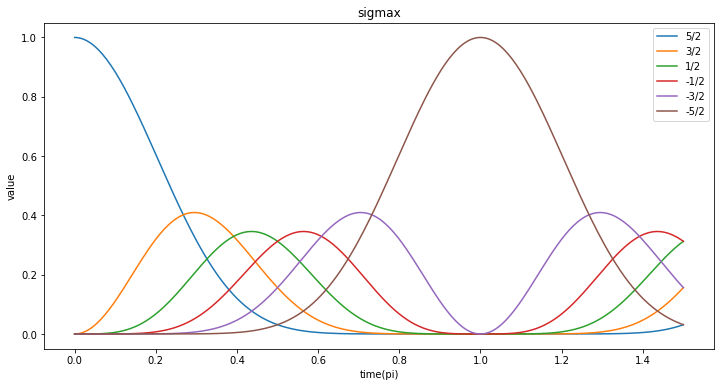

In [8]:
#布居数随时间演化(sigmax)#


t_ele = zeros((int(2*F+1),len(tlist)))

plt.figure(figsize=(12,6))
for ele_num in range(int(2*F+1)):
    
    for t_num in range(len(tlist)):
        t_ele[ele_num,t_num] = abs(t_state.states[t_num][ele_num])**2
        
    str1 = str(5-ele_num*2)
    str2 = '/2'
    plt.plot(tlist/pi,t_ele[ele_num,:],label = str1+str2)
    plt.legend()

plt.xlabel('time(pi)')
plt.ylabel('value')
plt.title('sigmax')
plt.show


In [9]:
#Hamiltonian#


#Ham = 
#print(Ham)
